In [ ]:
from Bio import SeqIO

file_path = "nucleotide_dependency_maps/output/download_fasta/GCF_000001735.4.fna.gz"

records = list(SeqIO.parse("file.fasta", "fasta"))
for record in records:
    print(record.id, len(record.seq))

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [28]:
my_input = torch.tensor([[[1.0,1.0,1.0], [2.0,2.0,2.0], [3.0,3.0,3.0], [4.0,4.0,4.0]]])
my_input

tensor([[[1., 1., 1.],
         [2., 2., 2.],
         [3., 3., 3.],
         [4., 4., 4.]]])

In [23]:
conv1d_layer = nn.Conv1d(in_channels=3, out_channels=2, kernel_size=1, padding='same')

conv1d_layer.weight.data = torch.tensor([[[0.1],  # Filter 1 for Channel 1
                                          [0.2],  # Filter 1 for Channel 2
                                          [0.3]], # Filter 1 for Channel 3
                                        
                                         [[0.4],  # Filter 2 for Channel 1
                                          [0.5],  # Filter 2 for Channel 2
                                          [0.6]], # Filter 2 for Channel 3
                                        ])

my_output = conv1d_layer(torch.transpose(my_input, 0, 1))
my_output

tensor([[0.9317, 1.5317, 2.1317, 2.7317],
        [1.4714, 2.9714, 4.4714, 5.9714]], grad_fn=<SqueezeBackward1>)

In [24]:
torch.transpose(my_output, 0, 1)

tensor([[0.9317, 1.4714],
        [1.5317, 2.9714],
        [2.1317, 4.4714],
        [2.7317, 5.9714]], grad_fn=<TransposeBackward0>)

In [26]:
my_gpn_con_layer = ConvLayer(hidden_size=3, kernel_size=1)

In [29]:
my_gpn_con_layer(my_input)

tensor([[[1.1847, 1.1149, 0.7004],
         [0.0458, 3.3364, 2.6179],
         [0.9004, 4.6743, 3.4252],
         [1.8387, 5.8302, 4.3311]]], grad_fn=<AddBackward0>)

In [31]:
my_gpn_con_layer.ffn(my_input)

tensor([[[-1.0329, -0.3200,  1.3529],
         [-1.2163, -0.0167,  1.2330],
         [-1.3117,  0.1980,  1.1137],
         [-1.3572,  0.3345,  1.0227]]], grad_fn=<NativeLayerNormBackward0>)

In [2]:
class TransposeLayer(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        return x

In [3]:
class ConvLayer(nn.Module):
    def __init__(
        self,
        hidden_size=None,
        **kwargs,
    ):
        super().__init__()
        self.conv = nn.Sequential(
            TransposeLayer(),
            nn.Conv1d(
                in_channels=hidden_size,
                out_channels=hidden_size,
                padding="same",
                **kwargs,
            ),
            TransposeLayer(),
            nn.GELU(),
            nn.LayerNorm(hidden_size),
        )
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.LayerNorm(hidden_size),
        )

    def forward(self, x):
        x = x + self.conv(x)
        x = x + self.ffn(x)
        return x

In [5]:
from gpn.data import load_fasta

genome = load_fasta("../data/Lan3.1.fna.gz")

genome

ModuleNotFoundError: No module named 'gpn'

In [1]:
import pandas as pd
from transformers import AutoModelForMaskedLM, AutoTokenizer

from datasets import Dataset
from torch.utils.data import DataLoader
import torch

# gpn specific model configuration
import gpn.model

In [3]:
model_path = "gonzalobenegas/gpn-brassicales"

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
print(f"tokenizer vocabulary: {tokenizer.get_vocab()}")

# load model
model = AutoModelForMaskedLM.from_pretrained(model_path)
device = "cuda"
model.to(device)
model.eval()


tokenizer vocabulary: {'[UNK]': 2, 'c': 4, '[MASK]': 1, '[PAD]': 0, 'a': 3, 'g': 5, 't': 6}


ConvNetForMaskedLM(
  (model): ConvNetModel(
    (embedding): GPNEmbedding()
    (encoder): Sequential(
      (0): ConvLayer(
        (conv): Sequential(
          (0): TransposeLayer()
          (1): Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=same)
          (2): TransposeLayer()
          (3): GELU(approximate='none')
          (4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
      )
      (1): ConvLayer(
        (conv): Sequential(
          (0): TransposeLayer()
          (1): Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=same, dilation=(2,))
          (2): TransposeLayer()
          (3): GELU(approximate='none')
          (4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): Sequential(
          (0

In [4]:
sequence = genome["chr1"]

sequence[:100]

'tacattacatcacaaaaagctaaacacaaagaatcatggattttagattttgatttccacaaaacagagaaatcgaacccgagattgaagaaataactaa'

In [5]:
input_ids = tokenizer(sequence[:100], return_tensors="pt")['input_ids']
input_ids

tensor([[6, 3, 4, 3, 6, 6, 3, 4, 3, 6, 4, 3, 4, 3, 3, 3, 3, 3, 5, 4, 6, 3, 3, 3,
         4, 3, 4, 3, 3, 3, 5, 3, 3, 6, 4, 3, 6, 5, 5, 3, 6, 6, 6, 6, 3, 5, 3, 6,
         6, 6, 6, 5, 3, 6, 6, 6, 4, 4, 3, 4, 3, 3, 3, 3, 4, 3, 5, 3, 5, 3, 3, 3,
         6, 4, 5, 3, 3, 4, 4, 4, 5, 3, 5, 3, 6, 6, 5, 3, 3, 5, 3, 3, 3, 6, 3, 3,
         4, 6, 3, 3]])

In [13]:
acgt_idxs = [tokenizer.get_vocab()[nuc] for nuc in ["a", "c", "g", "t"]]
acgt_idxs

[3, 4, 5, 6]

In [8]:
output = model(input_ids=input_ids.to(device))
output

MaskedLMOutput(loss=None, logits=tensor([[[-2.3540e+01, -2.3518e+01, -2.3536e+01, -9.0407e-02, -8.0914e-01,
          -1.4060e+00,  1.4619e+00],
         [-2.4035e+01, -2.4020e+01, -2.4031e+01,  1.5756e+00, -8.3412e-01,
          -1.3351e+00, -2.5225e-01],
         [-2.2805e+01, -2.2801e+01, -2.2807e+01, -2.6646e-01,  1.3379e+00,
          -6.7988e-01, -7.8255e-01],
         [-2.5066e+01, -2.5055e+01, -2.5065e+01,  2.3538e+00, -1.3703e+00,
          -1.3422e+00, -5.0256e-01],
         [-2.1550e+01, -2.1547e+01, -2.1557e+01, -2.0332e-01, -1.0884e+00,
          -1.3091e+00,  1.7758e+00],
         [-2.2333e+01, -2.2323e+01, -2.2331e+01, -3.9516e-01, -4.7684e-01,
          -1.4187e+00,  1.5041e+00],
         [-2.4298e+01, -2.4284e+01, -2.4291e+01,  1.7008e+00, -1.1026e+00,
          -1.0780e+00, -3.5907e-01],
         [-2.1856e+01, -2.1860e+01, -2.1863e+01, -3.1572e-01,  1.6464e+00,
          -7.8749e-01, -8.7744e-01],
         [-2.5194e+01, -2.5184e+01, -2.5194e+01,  2.4784e+00, -1.0682e+

In [19]:
nucleotide_logits = output.logits.cpu().to(torch.float32)[:, :, acgt_idxs]
scaled_logits = nucleotide_logits * 0.1
output_probs = torch.nn.functional.softmax(scaled_logits, dim=-1)
output_probs

tensor([[[0.2516, 0.2341, 0.2205, 0.2938],
         [0.2971, 0.2335, 0.2220, 0.2474],
         [0.2449, 0.2875, 0.2350, 0.2326],
         [0.3193, 0.2200, 0.2207, 0.2400],
         [0.2482, 0.2272, 0.2222, 0.3025],
         [0.2437, 0.2417, 0.2200, 0.2946],
         [0.3006, 0.2271, 0.2277, 0.2446],
         [0.2429, 0.2956, 0.2318, 0.2297],
         [0.3226, 0.2263, 0.2062, 0.2450],
         [0.2559, 0.2272, 0.2187, 0.2982],
         [0.2489, 0.2873, 0.2216, 0.2422],
         [0.3105, 0.2347, 0.2077, 0.2470],
         [0.2369, 0.2933, 0.2354, 0.2344],
         [0.3024, 0.2532, 0.2089, 0.2355],
         [0.2968, 0.2493, 0.2243, 0.2296],
         [0.2965, 0.2344, 0.2439, 0.2253],
         [0.2998, 0.2369, 0.2365, 0.2268],
         [0.3083, 0.2273, 0.2301, 0.2343],
         [0.2287, 0.2514, 0.2814, 0.2386],
         [0.2429, 0.2927, 0.2300, 0.2345],
         [0.2523, 0.2383, 0.2159, 0.2936],
         [0.3064, 0.2389, 0.2198, 0.2349],
         [0.3120, 0.2369, 0.2140, 0.2371],
         [0

In [5]:
def sliding_window_generator(
    sequence, start_position, stop_position, tokenizer, window_size=513, step_size=1
):
    """
    Generate sliding windows over a DNA sequence.

    Args:
        fasta_path (str): Path to the FASTA file
        window_size (int): Size of the sliding window
        step_size (int): Step size for sliding the window

    Yields:
        dict: A dictionary with the sequence window
    """
    seq_len = len(sequence)

    window_size_half = window_size // 2

    assert start_position - window_size_half - 1 >= 0
    assert stop_position + window_size_half - 1 <= seq_len

    for position in range(start_position, stop_position + 1, step_size):
        # arrays are 0-indexed, genomes 1-indexed
        position = position - 1

        start = int(position - window_size_half)
        end = int(position + window_size_half + 1)

        sequence_window = sequence[start:end]

        center = len(sequence_window) // 2

        tokenized_input = tokenizer(
            sequence_window,
            return_tensors="pt",
            return_attention_mask=False,
            return_token_type_ids=False,
        )

        # Remove the batch dimension for dataset compatibility
        tokenized_data = {k: v.squeeze(0) for k, v in tokenized_input.items()}

        # mask the center nucleotide
        tokenized_data["input_ids"][center] = tokenizer.mask_token_id
        tokenized_data["reference"] = sequence_window[center]

        # Add position information
        tokenized_data["position"] = position + 1 # back to genome index
        tokenized_data["sequence"] = (
            sequence_window  # Keep the original sequence for reference
        )

        yield tokenized_data

In [80]:
gen = sliding_window_generator(sequence, 10, 30, tokenizer, window_size=5)

In [81]:
next(gen)

{'input_ids': tensor([4, 3, 1, 4, 3]),
 'reference': 't',
 'position': 10,
 'sequence': 'catca'}

In [6]:
dataset = Dataset.from_generator(
    lambda: sliding_window_generator(
        sequence, 3, 98, tokenizer, window_size=5
    )
)

In [7]:
def collate_fn(batch):
    return {
        "input_ids": torch.tensor([item["input_ids"] for item in batch]),
        "reference": [item["reference"] for item in batch],
        "sequence": [item["sequence"] for item in batch],
        "position": [item["position"] for item in batch],
    }

In [8]:
batch_size = 16
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,  # For sliding windows, keep in order
)

In [9]:
all_predictions = []
acgt_idxs = [tokenizer.get_vocab()[nuc] for nuc in ["a", "c", "g", "t"]]

window_size = 5
center = window_size // 2
results = []

for batch in dataloader:
    # print(batch)
    # batch_results = []
    # for i in range(len(batch["input_ids"])):
    current_input = batch["input_ids"]
    
    # print(current_input)
    # print(current_input.shape)
    with torch.no_grad():
        all_logits = model(input_ids=current_input.to(device)).logits.cpu().to(torch.float32)
    
    nucleotide_logits = all_logits[:, :, acgt_idxs]
    output_probs = torch.nn.functional.softmax(nucleotide_logits, dim=-1)
    
    all_predictions.append(output_probs)

    for i in range(len(batch["input_ids"])):
        results.append({
            "position": batch["position"][i],
            "reference": batch["reference"][i],
            "p_a": output_probs[i][center][0],
            "p_c": output_probs[i][center][1],
            "p_g": output_probs[i][center][2],
            "p_t": output_probs[i][center][3]
        }
        )
    
    # print(batch_results)
    # print(model(**batch))
    # print(model(input_ids=batch.to(device)).logits.cpu().to(torch.float32))

# print(all_predictions)
results = pd.DataFrame(results)
results

,position,reference,p_a,p_c,p_g,p_t
0,3,c,tensor(0.2848),tensor(0.1555),tensor(0.1534),tensor(0.4063)
1,4,a,tensor(0.3722),tensor(0.1678),tensor(0.1348),tensor(0.3252)
2,5,t,tensor(0.3382),tensor(0.1370),tensor(0.1793),tensor(0.3454)
3,6,t,tensor(0.2366),tensor(0.3201),tensor(0.1349),tensor(0.3083)
4,7,a,tensor(0.2398),tensor(0.1684),tensor(0.2458),tensor(0.3459)
...,...,...,...,...,...,...
91,94,t,tensor(0.2969),tensor(0.2202),tensor(0.2690),tensor(0.2139)
92,95,a,tensor(0.2366),tensor(0.3201),tensor(0.1349),tensor(0.3083)
93,96,a,tensor(0.2610),tensor(0.1427),tensor(0.2131),tensor(0.3831)
94,97,c,tensor(0.3351),tensor(0.1238),tensor(0.1086),tensor(0.4325)


In [25]:
# p_reference = results['p_' + results['reference']]

import numpy as np

df = results

p_reference = [row[col] for row, col in zip(df.to_dict('records'), 'p_' + df['reference'])]

# p_reference
results['gpn_a'] = results['p_a'] / p_reference
results['gpn_c'] = results['p_c'] / p_reference

results[['gpn_a', 'gpn_c']] = np.log2(results[['gpn_a', 'gpn_c']])

results

df = results

df = df.map(lambda x: x.item() if torch.is_tensor(x) and x.numel() == 1 else x)

df

,position,reference,p_a,p_c,p_g,p_t,selected,gpn_a,gpn_c
0,3,c,0.284806,0.155489,0.153386,0.406319,0.155489,0.873169,0.000000
1,4,a,0.372197,0.167824,0.134777,0.325202,0.372197,0.000000,-1.149117
2,5,t,0.338208,0.137048,0.179338,0.345406,0.345406,-0.030380,-1.333612
3,6,t,0.236602,0.320111,0.134939,0.308348,0.308348,-0.382099,0.054014
4,7,a,0.239819,0.168436,0.245846,0.345899,0.239819,0.000000,-0.509739
...,...,...,...,...,...,...,...,...,...
91,94,t,0.296884,0.220174,0.268993,0.213949,0.213949,0.472638,0.041378
92,95,a,0.236602,0.320111,0.134939,0.308348,0.236602,0.000000,0.436113
93,96,a,0.261034,0.142738,0.213091,0.383137,0.261034,0.000000,-0.870864
94,97,c,0.335135,0.123814,0.108599,0.432451,0.123814,1.436563,0.000000


In [ ]:
nucleotides = ["a", "c", "g", "t"]
alternatives = [n for n in nucleotides if n != reference_nucleotide]

gpn_scores = probabilities_per_context_length

for alt in alternatives:
    gpn_scores[f"gpn_{alt}"] = gpn_scores[alt] / gpn_scores[reference_nucleotide]

In [3]:
!pip install biopython

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for biopython from https://files.pythonhosted.org/packages/25/9c/612821b946930b6caa5d795cfe4169ed6a522562eced9776914be7efaf21/biopython-1.85-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/ad/c9/1bf6ada582eebcbe8978f5feb26584cd2b39f94ededeea034ca8f84af8c8/numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 80.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 100.1 MB/s eta 0:00:0000:0100:01


In [21]:
from Bio.Seq import Seq
from Bio import SeqIO
import gzip

ModuleNotFoundError: No module named 'pandas'

In [35]:
file_path = "high_throughput_gpn_computation/resources/B3_long_genes.fasta"

sequence = ""

from Bio import SeqIO
# with gzip.open(file_path, "rt") as handle:
records = list(SeqIO.parse(file_path, "fasta"))

names = []

for record in records:
    print(record.id, len(record.seq))
    names.append(record.id)
    

fwd::AccID1925|tig00000049:3041-6378 3337
fwd::AccID1925|tig00000049:8135-11119 2885
fwd::AccID5993|tig00000115:3634-5812 2178
fwd::AccID6899|tig00000128:2515-5681 3166
fwd::AccID6906|tig00000007:13910-17050 3140
fwd::AccID6906|tig00000007:2204-5350 3146
fwd::AccID6906|tig00000007:8230-11022 2792
fwd::AccID6924|tig00000062:2370-4184 1814
fwd::AccID6939|tig00000031:2959-6215 3256
fwd::AccID6939|tig00000031:9021-12010 2989
fwd::AccID6939|tig00000145:2337-5461 3124
fwd::AccID6981|tig00000112:1855-4963 3108
fwd::AccID7058|tig00000009:1803-5004 3201
fwd::AccID7058|tig00000009:7773-10686 2913
fwd::AccID7058|tig00000016:3734-6792 3058
fwd::AccID7067|tig00000089:1956-5141 3185
fwd::AccID7111|tig00000075:1932-5216 3284
fwd::AccID7273|tig00000028:1383-4635 3252
fwd::AccID7273|tig00000028:7394-10589 3195
fwd::AccID7288|tig00000036:14474-17662 3188
fwd::AccID7288|tig00000036:8810-11999 3189
fwd::AccID7288|tig00000091:3888-6478 2590
fwd::AccID7322|tig00000075:1559-4754 3195
fwd::AccID7328|tig000000

In [37]:
names

['fwd::AccID1925|tig00000049:3041-6378',
 'fwd::AccID1925|tig00000049:8135-11119',
 'fwd::AccID5993|tig00000115:3634-5812',
 'fwd::AccID6899|tig00000128:2515-5681',
 'fwd::AccID6906|tig00000007:13910-17050',
 'fwd::AccID6906|tig00000007:2204-5350',
 'fwd::AccID6906|tig00000007:8230-11022',
 'fwd::AccID6924|tig00000062:2370-4184',
 'fwd::AccID6939|tig00000031:2959-6215',
 'fwd::AccID6939|tig00000031:9021-12010',
 'fwd::AccID6939|tig00000145:2337-5461',
 'fwd::AccID6981|tig00000112:1855-4963',
 'fwd::AccID7058|tig00000009:1803-5004',
 'fwd::AccID7058|tig00000009:7773-10686',
 'fwd::AccID7058|tig00000016:3734-6792',
 'fwd::AccID7067|tig00000089:1956-5141',
 'fwd::AccID7111|tig00000075:1932-5216',
 'fwd::AccID7273|tig00000028:1383-4635',
 'fwd::AccID7273|tig00000028:7394-10589',
 'fwd::AccID7288|tig00000036:14474-17662',
 'fwd::AccID7288|tig00000036:8810-11999',
 'fwd::AccID7288|tig00000091:3888-6478',
 'fwd::AccID7322|tig00000075:1559-4754',
 'fwd::AccID7328|tig00000056:4784-7868',
 'fwd:

In [19]:
sequence.find("N")

197530

In [7]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/cd/5f/4dba1d39bb9c38d574a9a22548c540177f78ea47b32f99c0ff2ec499fac5/pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.7 MB/s eta 0:00:00
  Obtaining dependency information for tzdata>=2022.7 from https://files.pythonhosted.org/packages/5c/23/c7abc0ca0a1526a0774eca151daeb8de62ec457e77262b66b359c3c7679e/tzdata-2025.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 104.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 91.6 MB/s eta 0:00:00


In [9]:
import pandas as pd

In [11]:
a = pd.DataFrame([0, 1, 2])

In [19]:
a = a[::-1]

In [21]:
a

,0
2,2
1,1
0,0


In [27]:
b = [0, 1, 2]

In [31]:
b[len(b)-1]

2

In [63]:
[3**i for i in range(12)]

[1, 3, 9, 27, 81, 243, 729, 2187, 6561, 19683, 59049, 177147]

In [29]:
def count_contig(arr):
    def update(state, curr):
        last, pos, acc = state
        if last == None:
            acc.append(1)
            return (curr, pos, acc)
        if curr == last:
            acc[pos] += 1
            return (curr, pos, acc)
        else:
            acc.append(1)
            return (curr, pos+1, acc)
        
    _, _, result = reduce(update, arr, (None, 0, []))
    return result

In [34]:
count_contig([1,1, 2,3 , 2, 1, 1])

[2, 1, 1, 1, 2]

In [1]:
import numpy as np
import matplotlib as plot
import pandas as pd

from functools import reduce

In [2]:
def kernel(layer, kernel_size, dilation_base):
    dilation = dilation_base**layer
    kernel = np.zeros(1 + dilation * (kernel_size - 1))
    for i in range(len(kernel)):
        if i % dilation == 0:
            kernel[i] = 1
    return kernel

In [3]:
kernel(0,3,1)

array([1., 1., 1.])

In [35]:
k = 3
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(2)])
print(len(rf))
print(count_contig(rf))
rf

9
[9]


array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [36]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(1)])
print(len(rf))
print(count_contig(rf))
rf

9
[9]


array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [37]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(2)])
print(len(rf))
print(count_contig(rf))
rf

33
[3, 3, 21, 3, 3]


array([1., 1., 1., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 1., 1., 1.])

In [38]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(3)])
print(len(rf))
print(count_contig(rf))
rf

105
[3, 3, 3, 3, 3, 3, 3, 3, 57, 3, 3, 3, 3, 3, 3, 3, 3]


array([1., 1., 1., 2., 2., 2., 3., 3., 3., 4., 4., 4., 5., 5., 5., 6., 6.,
       6., 7., 7., 7., 8., 8., 8., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
       9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 8., 8., 8., 7.,
       7., 7., 6., 6., 6., 5., 5., 5., 4., 4., 4., 3., 3., 3., 2., 2., 2.,
       1., 1., 1.])

In [39]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(4)])
print(len(rf))
print(count_contig(rf))
rf

321
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 165, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


array([ 1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.,  5.,
        5.,  5.,  6.,  6.,  6.,  7.,  7.,  7.,  8.,  8.,  8.,  9.,  9.,
        9., 10., 10., 10., 11., 11., 11., 12., 12., 12., 13., 13., 13.,
       14., 14., 14., 15., 15., 15., 16., 16., 16., 17., 17., 17., 18.,
       18., 18., 19., 19., 19., 20., 20., 20., 21., 21., 21., 22., 22.,
       22., 23., 23., 23., 24., 24., 24., 25., 25., 25., 26., 26., 26.,
       27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
       27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
       27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
       27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
       27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
       27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
       27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
       27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27

In [40]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(5)])
print(len(rf))
print(count_contig(rf))
rf

969
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 489, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


array([ 1.,  1.,  1.,  2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.,  5.,
        5.,  5.,  6.,  6.,  6.,  7.,  7.,  7.,  8.,  8.,  8.,  9.,  9.,
        9., 10., 10., 10., 11., 11., 11., 12., 12., 12., 13., 13., 13.,
       14., 14., 14., 15., 15., 15., 16., 16., 16., 17., 17., 17., 18.,
       18., 18., 19., 19., 19., 20., 20., 20., 21., 21., 21., 22., 22.,
       22., 23., 23., 23., 24., 24., 24., 25., 25., 25., 26., 26., 26.,
       27., 27., 27., 28., 28., 28., 29., 29., 29., 30., 30., 30., 31.,
       31., 31., 32., 32., 32., 33., 33., 33., 34., 34., 34., 35., 35.,
       35., 36., 36., 36., 37., 37., 37., 38., 38., 38., 39., 39., 39.,
       40., 40., 40., 41., 41., 41., 42., 42., 42., 43., 43., 43., 44.,
       44., 44., 45., 45., 45., 46., 46., 46., 47., 47., 47., 48., 48.,
       48., 49., 49., 49., 50., 50., 50., 51., 51., 51., 52., 52., 52.,
       53., 53., 53., 54., 54., 54., 55., 55., 55., 56., 56., 56., 57.,
       57., 57., 58., 58., 58., 59., 59., 59., 60., 60., 60., 61

In [55]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(6)])
print(len(rf))
print(count_contig(rf))
[f, _, e] = count_contig(count_contig(rf))
print("peripheral: " + str((f + e) * 3 / len(rf)))
print("center: " + str(max(count_contig(rf)) / len(rf)))

2913
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1461, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [56]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(7)])
print(len(rf))
print(count_contig(rf))
[f, _, e] = count_contig(count_contig(rf))
print("peripheral: " + str((f + e) * 3 / len(rf)))
print("center: " + str(max(count_contig(rf)) / len(rf)))

8745
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [57]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(8)])
print(len(rf))
print(count_contig(rf))
[f, _, e] = count_contig(count_contig(rf))
print("peripheral: " + str((f + e) * 3 / len(rf)))
print("center: " + str(max(count_contig(rf)) / len(rf)))

26241
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [59]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(9)])
print(len(rf))
# print(count_contig(rf))
[f, _, e] = count_contig(count_contig(rf))
print("peripheral: " + str((f + e) * 3 / len(rf)))
print("center: " + str(max(count_contig(rf)) / len(rf)))

78729
peripheral: 0.4999428419006973
center: 0.5000571580993026


In [60]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(10)])
print(len(rf))
# print(count_contig(rf))
[f, _, e] = count_contig(count_contig(rf))
print("peripheral: " + str((f + e) * 3 / len(rf)))
print("center: " + str(max(count_contig(rf)) / len(rf)))

236193
peripheral: 0.4999809477842273
center: 0.5000190522157727


In [61]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(11)])
print(len(rf))
# print(count_contig(rf))
[f, _, e] = count_contig(count_contig(rf))
print("peripheral: " + str((f + e) * 3 / len(rf)))
print("center: " + str(max(count_contig(rf)) / len(rf)))

708585
peripheral: 0.4999936493151845
center: 0.5000063506848155


In [62]:
k = 9
b = 3
rf = reduce(np.convolve, [kernel(i, k, b) for i in range(12)])
print(len(rf))
# print(count_contig(rf))
[f, _, e] = count_contig(count_contig(rf))
print("peripheral: " + str((f + e) * 3 / len(rf)))
print("center: " + str(max(count_contig(rf)) / len(rf)))

2125761
peripheral: 0.4999978831110365
center: 0.5000021168889636


In [18]:
df = pd.DataFrame([
    reduce(np.convolve, [kernel(i, 3, 1) for i in range(6)]),
    reduce(np.convolve, [kernel(i, 5, 2) for i in range(6)]),
    reduce(np.convolve, [kernel(i, 9, 3) for i in range(4)]),
    reduce(np.convolve, [kernel(i, 3, 3) for i in range(5)])
], index=["k3.b1.l6","k5.b2.l6","k9.b3.l4","k3.b3.l5"])

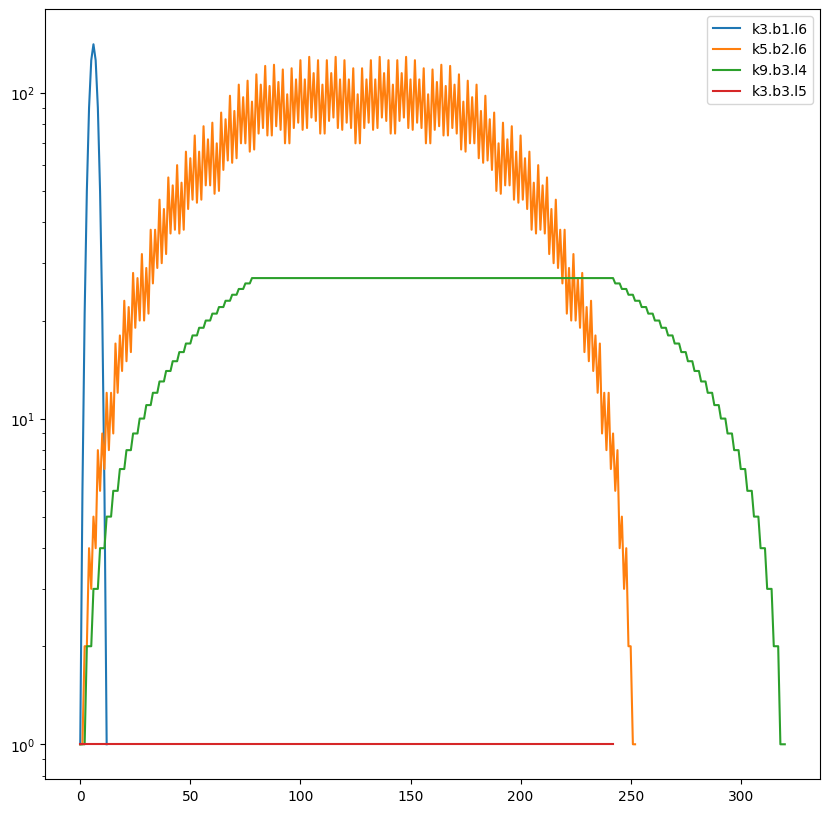

In [19]:
fig = df.T.plot(logy=True, figsize=(10, 10)).get_figure()

In [20]:
fig.savefig("path_distribution.png")

In [3]:
df = pd.DataFrame([
    reduce(np.convolve, [kernel(i, 9, 2) for i in range(6)]),
    reduce(np.convolve, [kernel(i, 5, 2) for i in range(8)]),
    reduce(np.convolve, [kernel(i, 9, 3) for i in range(5)]),
], index=["k9.b2.l6","k5.b2.l8","k9.b3.l5"])

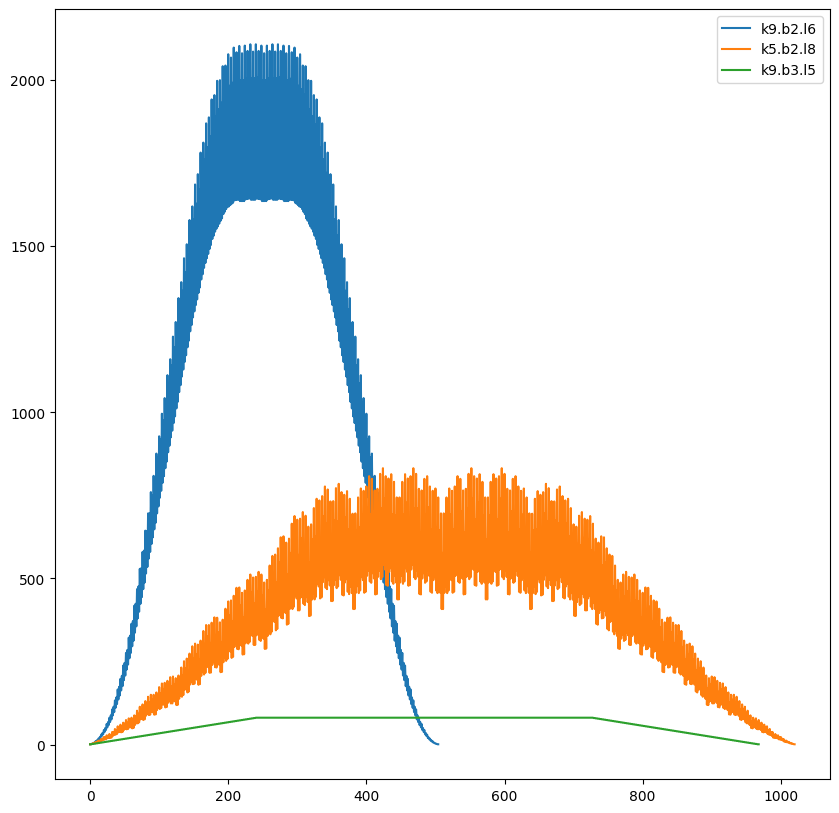

In [4]:
fig = df.T.plot(figsize=(10, 10)).get_figure()

In [9]:
fig.savefig("path_distribution_models.png")

In [5]:
def center_pad_np(arr, target_len, **pad_kw):
    m = target_len - len(arr)
    return np.pad(arr, (m // 2, m - m // 2), **pad_kw)

In [11]:
data = [
    reduce(np.convolve, [kernel(i, 9, 2) for i in range(6)]),
    reduce(np.convolve, [kernel(i, 5, 2) for i in range(8)]),
    reduce(np.convolve, [kernel(i, 9, 3) for i in range(5)]),
]

max_len = max(a.size for a in data)

cols = [center_pad_np(a, max_len, constant_values=np.nan) for a in data]
result  = np.column_stack(cols)
result

array([[nan,  1., nan],
       [nan,  1., nan],
       [nan,  2., nan],
       ...,
       [nan,  2., nan],
       [nan,  1., nan],
       [nan,  1., nan]])

In [19]:
df = pd.DataFrame(result, columns=["k9.b2.l6","k5.b2.l8","k9.b3.l5"])
center_df_index(df)

In [21]:
def center_df_index(df: pd.DataFrame) -> pd.DataFrame:
    n     = len(df)
    start = -n // 2            # left-of-centre row
    new_i = np.arange(start, start + n)
    df.index = new_i

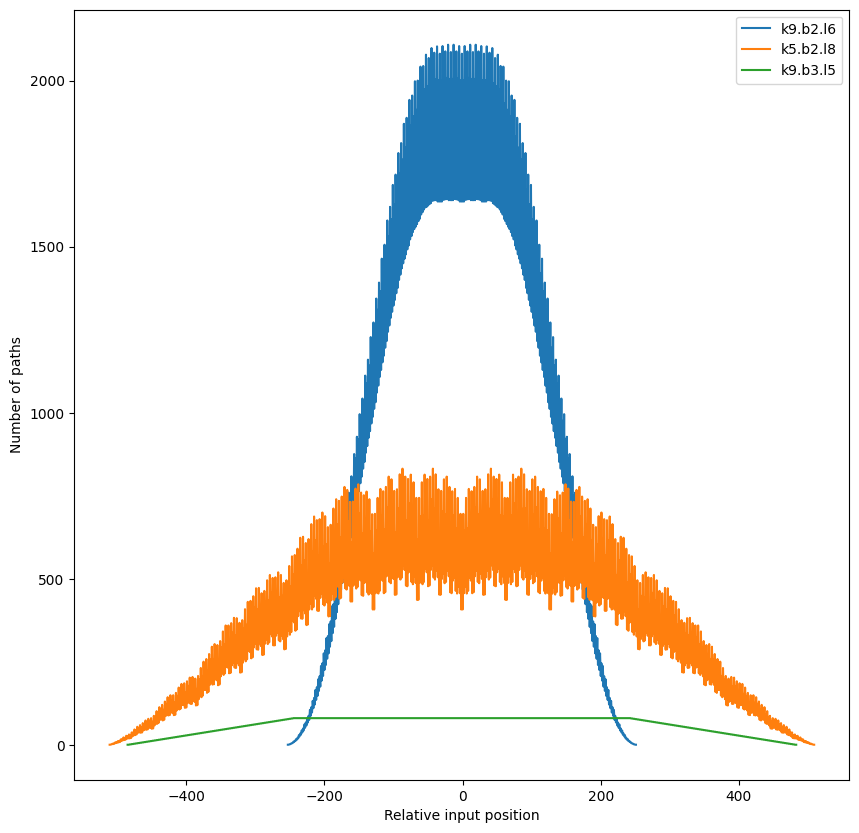

In [22]:
fig = df.plot(figsize=(10, 10), xlabel="Relative input position", ylabel="Number of paths").get_figure()

In [23]:
fig.savefig("path_distribution_models.png")

In [26]:
data = [
    reduce(np.convolve, [kernel(i, 3, 1) for i in range(6)]),
    reduce(np.convolve, [kernel(i, 5, 2) for i in range(6)]),
    reduce(np.convolve, [kernel(i, 9, 3) for i in range(4)]),
    reduce(np.convolve, [kernel(i, 3, 3) for i in range(5)])
]

max_len = max(a.size for a in data)

cols = [center_pad_np(a, max_len, constant_values=np.nan) for a in data]
result  = np.column_stack(cols)

df = pd.DataFrame(result, columns=["k3.b1.l6","k5.b2.l6","k9.b3.l4","k3.b3.l5"])
center_df_index(df)

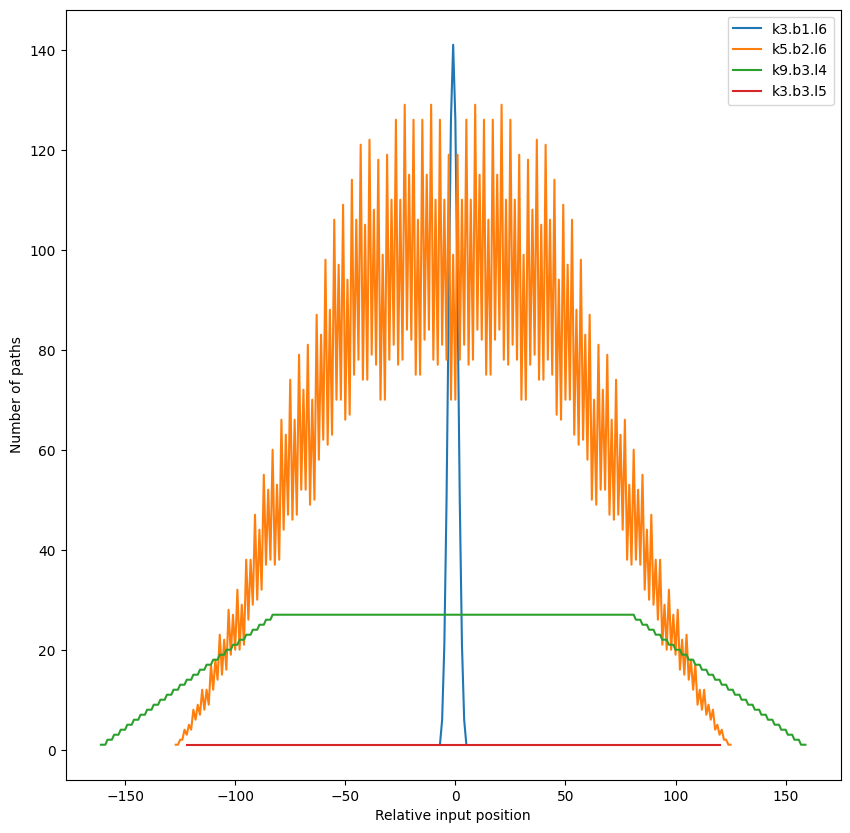

In [27]:
fig = df.plot(figsize=(10, 10), xlabel="Relative input position", ylabel="Number of paths").get_figure()

In [28]:
fig.savefig("path_distribution.png")